# Twiss

This is an example of plotting lines and twiss results.
First, create a simple line and a tracker:

In [1]:
import xtrack as xt
import xpart as xp
import xplt
import numpy as np

In [2]:
## Generate a simple 6-fold symmetric FODO lattice

n = 6  # number of sections
s = 5  # number of dipole slices
elements = {
    "QF": xt.Multipole(length=0.3, knl=[0, +0.63]),
    "QD": xt.Multipole(length=0.3, knl=[0, -0.48]),
    "MU": xt.Multipole(length=0.5, knl=[np.pi / n], hxl=[np.pi / n]),
}
parts = {
    "a": [xt.Node(0.7, "QF"), xt.Node(1.4, "MU"), xt.Node(2.1, "QD"), xt.Node(2.8, "MU")],
    "b": [xt.Node(2.2, "MU"), xt.Node(2.9, "QD"), xt.Node(3.6, "MU"), xt.Node(4.3, "QF")],
}
nodes = [xt.Node(5.0 * i, "a" if i % 2 else "b", name=f"S{i+1}") for i in range(n)]

line = xt.Line.from_sequence(
    nodes, length=5.0 * n, sequences=parts, elements=elements, auto_reorder=True
)
line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=1e9)
tracker = xt.Tracker(line=line)

Then determine it's twiss parameters. We use the `at_s` parameter to get the result as function of s rather than at each element only.

In [3]:
tw = tracker.twiss(
    method="4d",
    at_s=np.linspace(0, line.get_length(), 500, endpoint=False),
)
print(f"qx: {tw.qx:g}")
print(f"qy: {tw.qy:g}")

qx: 2.3309
qy: 1.12127


## Default twiss plot

Create a default {class}`TwissPlot <xplt.twiss.TwissPlot>`:

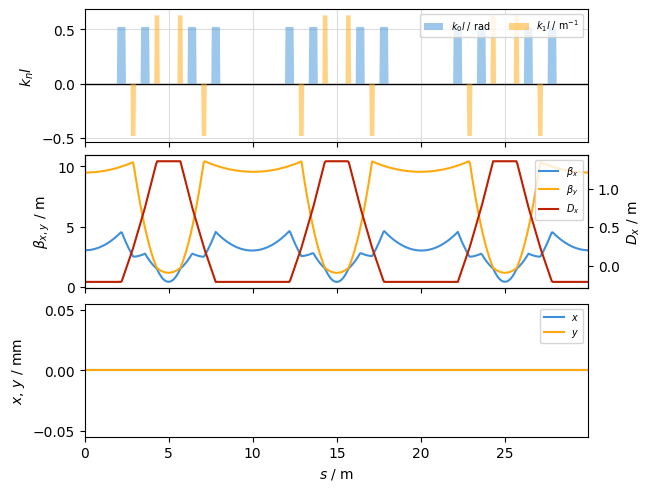

In [4]:
plot = xplt.TwissPlot(tw, line=line)

## Customisation

Use the parameter `kind` to specify what is plotted. See {class}`TwissPlot <xplt.twiss.TwissPlot>` for details.

In [5]:
print(", ".join(sorted(tw.keys(), key=lambda a: a.lower())))

_ebe_fields, alfx, alfy, betx, betx1, betx2, bety, bety1, bety2, betz0, c_minus, circumference, delta, dpx, dpy, dqx, dqy, dx, dy, dzeta, gamx, gamy, momentum_compaction_factor, mux, muy, muzeta, name, particle_on_co, ptau, px, py, qs, qx, qy, R_matrix, s, slip_factor, T_rev, values_at, W_matrix, x, y, zeta


```{tip}
Use prefix notation as shorthand to plot both x- and y-properties, e.g. `bet` for `betx+bety`
```

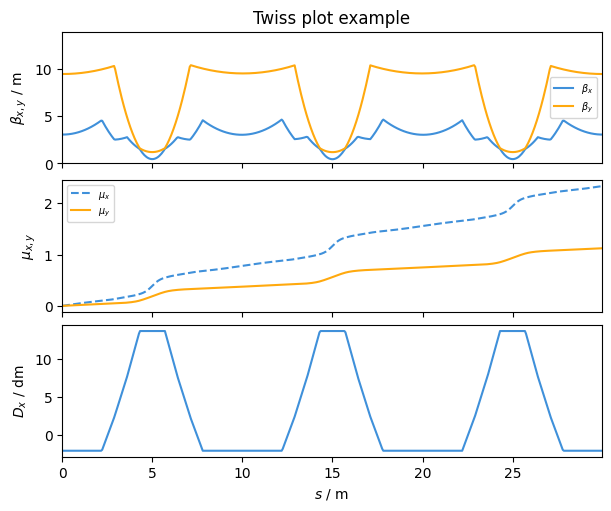

In [6]:
plot = xplt.TwissPlot(tw, figsize=(6, 5), kind="bet,mux+muy,dx", display_units=dict(d="dm"))

# adjust some axes
plot.ax[0].set(title="Twiss plot example", ylim=(0, 14))
plot.ax[0].legend(loc="right")

# adjust line layout
plot.artists[1][0][0].set_ls("--")
plot.ax[1].legend();

-----------------
```{seealso}
- {class}`xplt.twiss`
```